# Pachyderm - AWS Sagemaker Integration: Automatically Train ML Models on Version Controlled Datasets

> This project was created by [Winder Research, an ML consultancy](https://WinderResearch.com), and funded by [Pachyderm](https://pachyderm.com).

[Pachyderm](https://pachyderm.com) is a data science platform that combines data lineage with end-to-end pipelines.
Its data versioninig feature allows you to inspect, diff and rollback commits with a single line of code.
[AWS Sagemaker](https://aws.amazon.com/sagemaker/) is a managed ML platform to create, train, and deploy machine-learning models in the cloud. 
Sagemaker ships with powerful pre-packaged ML models that you can train without taking care of the infrastructure; the resource provisioning is all taken care of, all you have to do is select the machine type.



This notebook shows an example integration of Pachyderm and AWS Sagemaker to train a machine-learning model for customer churn prediction.
Customer churn is costly to many businesses but with ML you can possibly identify unhappy customers early on and offer them an incentive to stay.
In this example, I use a historical dataset comprising of demographics and usage records (e.g. calls/day, night calls, etc.) to predict whether a customer is going to churn.




The purpose of this demo is to show how Pachyderm can be used in concert with Sagemaker to train a model in the cloud and version control your artifacts (i.e. training data, trained model & metadata).
Therefore, I'll demonstrate the sufficient Pachyderm work needed to fit a model in Sagemaker; a similar workflow would apply for other Sagemaker features such as model deployment or data processing.

## Prerequisites

Both Pachyderm Hub and Sagemaker are managed services so all you need to install is their respective clients:

* A [Pachyderm client](https://docs.pachyderm.com/latest/getting_started/local_installation/#install-pachctl) (i.e. `pachctl`) installed on your local machine
* A workspace on [Pachyderm Hub](https://hub.pachyderm.com/); follow their instructions to authenticate `pachctl`
* An AWS account with an execution role attached comprising of the `AmazonSageMakerFullAccess` policy
* A [AWS Command Line Interface V2](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html) installed and [configured with your AWS key ID](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-quickstart.html#cli-configure-quickstart-creds)
* Python to run this notebook

Now, let us set up some configuration that will be used througout the notebook.

In [1]:
BUCKET_NAME = "sagemaker-YOUR_BUCKET_NAME" # make sure the `sagemaker` substring is included in the bucket name
AWS_BUCKET = "s3://" + BUCKET_NAME
AWS_DEFAULT_REGION = "us-west-2" # bucket and Sagemaker instance must reside in the same region
AWS_ACCESS_KEY_ID = "YOUR_AWS_ACCESS_KEY_ID"
AWS_SECRET_ACCESS_KEY = "YOUR_AWS_SECRET_ACCESS_KEY"
AWS_SAGEMAKER_ROLE = "arn:aws:iam::xxxxxxxxx:role/SageMaker-EMR-ExecutionRole"

## Check Pachyderm cluster

In [2]:
!pachctl version

COMPONENT           VERSION             
pachctl             1.13.3              
pachd               1.12.5              


To access Pachyderm dashboard, head to https://hub.pachyderm.com/ and click on the meatballs menu (three horizontal dots) on the workspace list.

## Add Training Data

Below I create a training data repository and populate it with the publicly available customer churn dataset used in [this tutorial](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html); it's attributed to the University of California Irvine Repository of Machine Learning Datasets and contains features like State, Area Code, Day Calls, Intl Calls, etc.
For the sake of brevity, I have pre-processed the dataset with dummy encoding for the categorical features.

In [3]:
!pachctl create repo churn_dataset

In [4]:
!pachctl list repo

NAME          CREATED                SIZE (MASTER) ACCESS LEVEL 
churn_dataset Less than a second ago 0B            OWNER         


The process of training a ML model usually involves using two datasets, one for fitting the actual model weights (`train.csv`) and one for driving the training run accross hyperparameter tuning, reducing bias, etc. (`validation.csv`).

In [5]:
!pachctl put file churn_dataset@master:train.csv -f dataset/train.csv
!pachctl put file churn_dataset@master:validation.csv -f dataset/validation.csv

dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB / 943.50 KB [===========================] 0s 0.00 b/s
dataset/train.csv 943.50KB /

## Create pipeline: Copy Churn Data from Pachyderm to AWS S3

I create a pipeline to copy my churn dataset from Pachyderm to AWS so that Sagemaker can use it.
Firstly I make an AWS bucket (name must contain `sagemaker`) in the same region I use for Sagemaker, then I build a simple pipeline to copy the content of `churn_dataset` repo to the target AWS bucket.

### Important

This pipeline could be simplified by using the [`egress` pipeline option](https://docs.pachyderm.com/latest/how-tos/basic-data-operations/export-data-out-pachyderm/export-data-egress/). 
I'd just copy data from `/pfs/churn_dataset/` to `/pfs/out/` and Pachyderm takes care of pushing it to AWS S3.
However, `egress` requires a credentials setup that's not exposed in Pachyderm Hub so for the time being it's not viable.

In [6]:
!aws s3 mb {AWS_BUCKET} --region {AWS_DEFAULT_REGION}

make_bucket: pachyderm-sagemaker-integration-example-1


In [7]:
pipeline = """
{
  "pipeline": {
    "name": "copy_to_s3"
  },
  "description": "Copy training data to AWS.",
  "transform": {
    "image": "winderresearch/example-pachyderm-copy-to-aws-s3:0.0.1",
    "cmd": ["/bin/bash"],
    "stdin": [
        "python -u /pach_to_aws.py --target_bucket %s"
    ],
    "env": {
        "AWS_DEFAULT_REGION": "%s",
        "AWS_ACCESS_KEY_ID": "%s",
        "AWS_SECRET_ACCESS_KEY": "%s"
    }
  },
  "parallelism_spec": {
    "constant": "1"
  },
  "input": {
    "pfs": {
      "repo": "churn_dataset",
      "branch": "master",
      "glob": "/"
    }
  }
}""" % (BUCKET_NAME, AWS_DEFAULT_REGION, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

print(pipeline, file=open('copy_to_s3.json', 'w'))

In [8]:
!pachctl create pipeline -f copy_to_s3.json

In [9]:
!pachctl flush commit copy_to_s3@master --raw > /dev/null 2>&1

In [10]:
!pachctl logs --pipeline=copy_to_s3

Passing data on to AWS S3
AWS S3 bucket 'pachyderm-sagemaker-integration-example-1' content:
train.csv
validation.csv


Verify data has been copied to AWS.

In [11]:
!aws s3 ls {BUCKET_NAME}

2021-08-11 11:56:55     943498 train.csv
2021-08-11 11:56:56     269544 validation.csv


This is what the current Pachyderm directed acyclic graph (DAG) looks like:

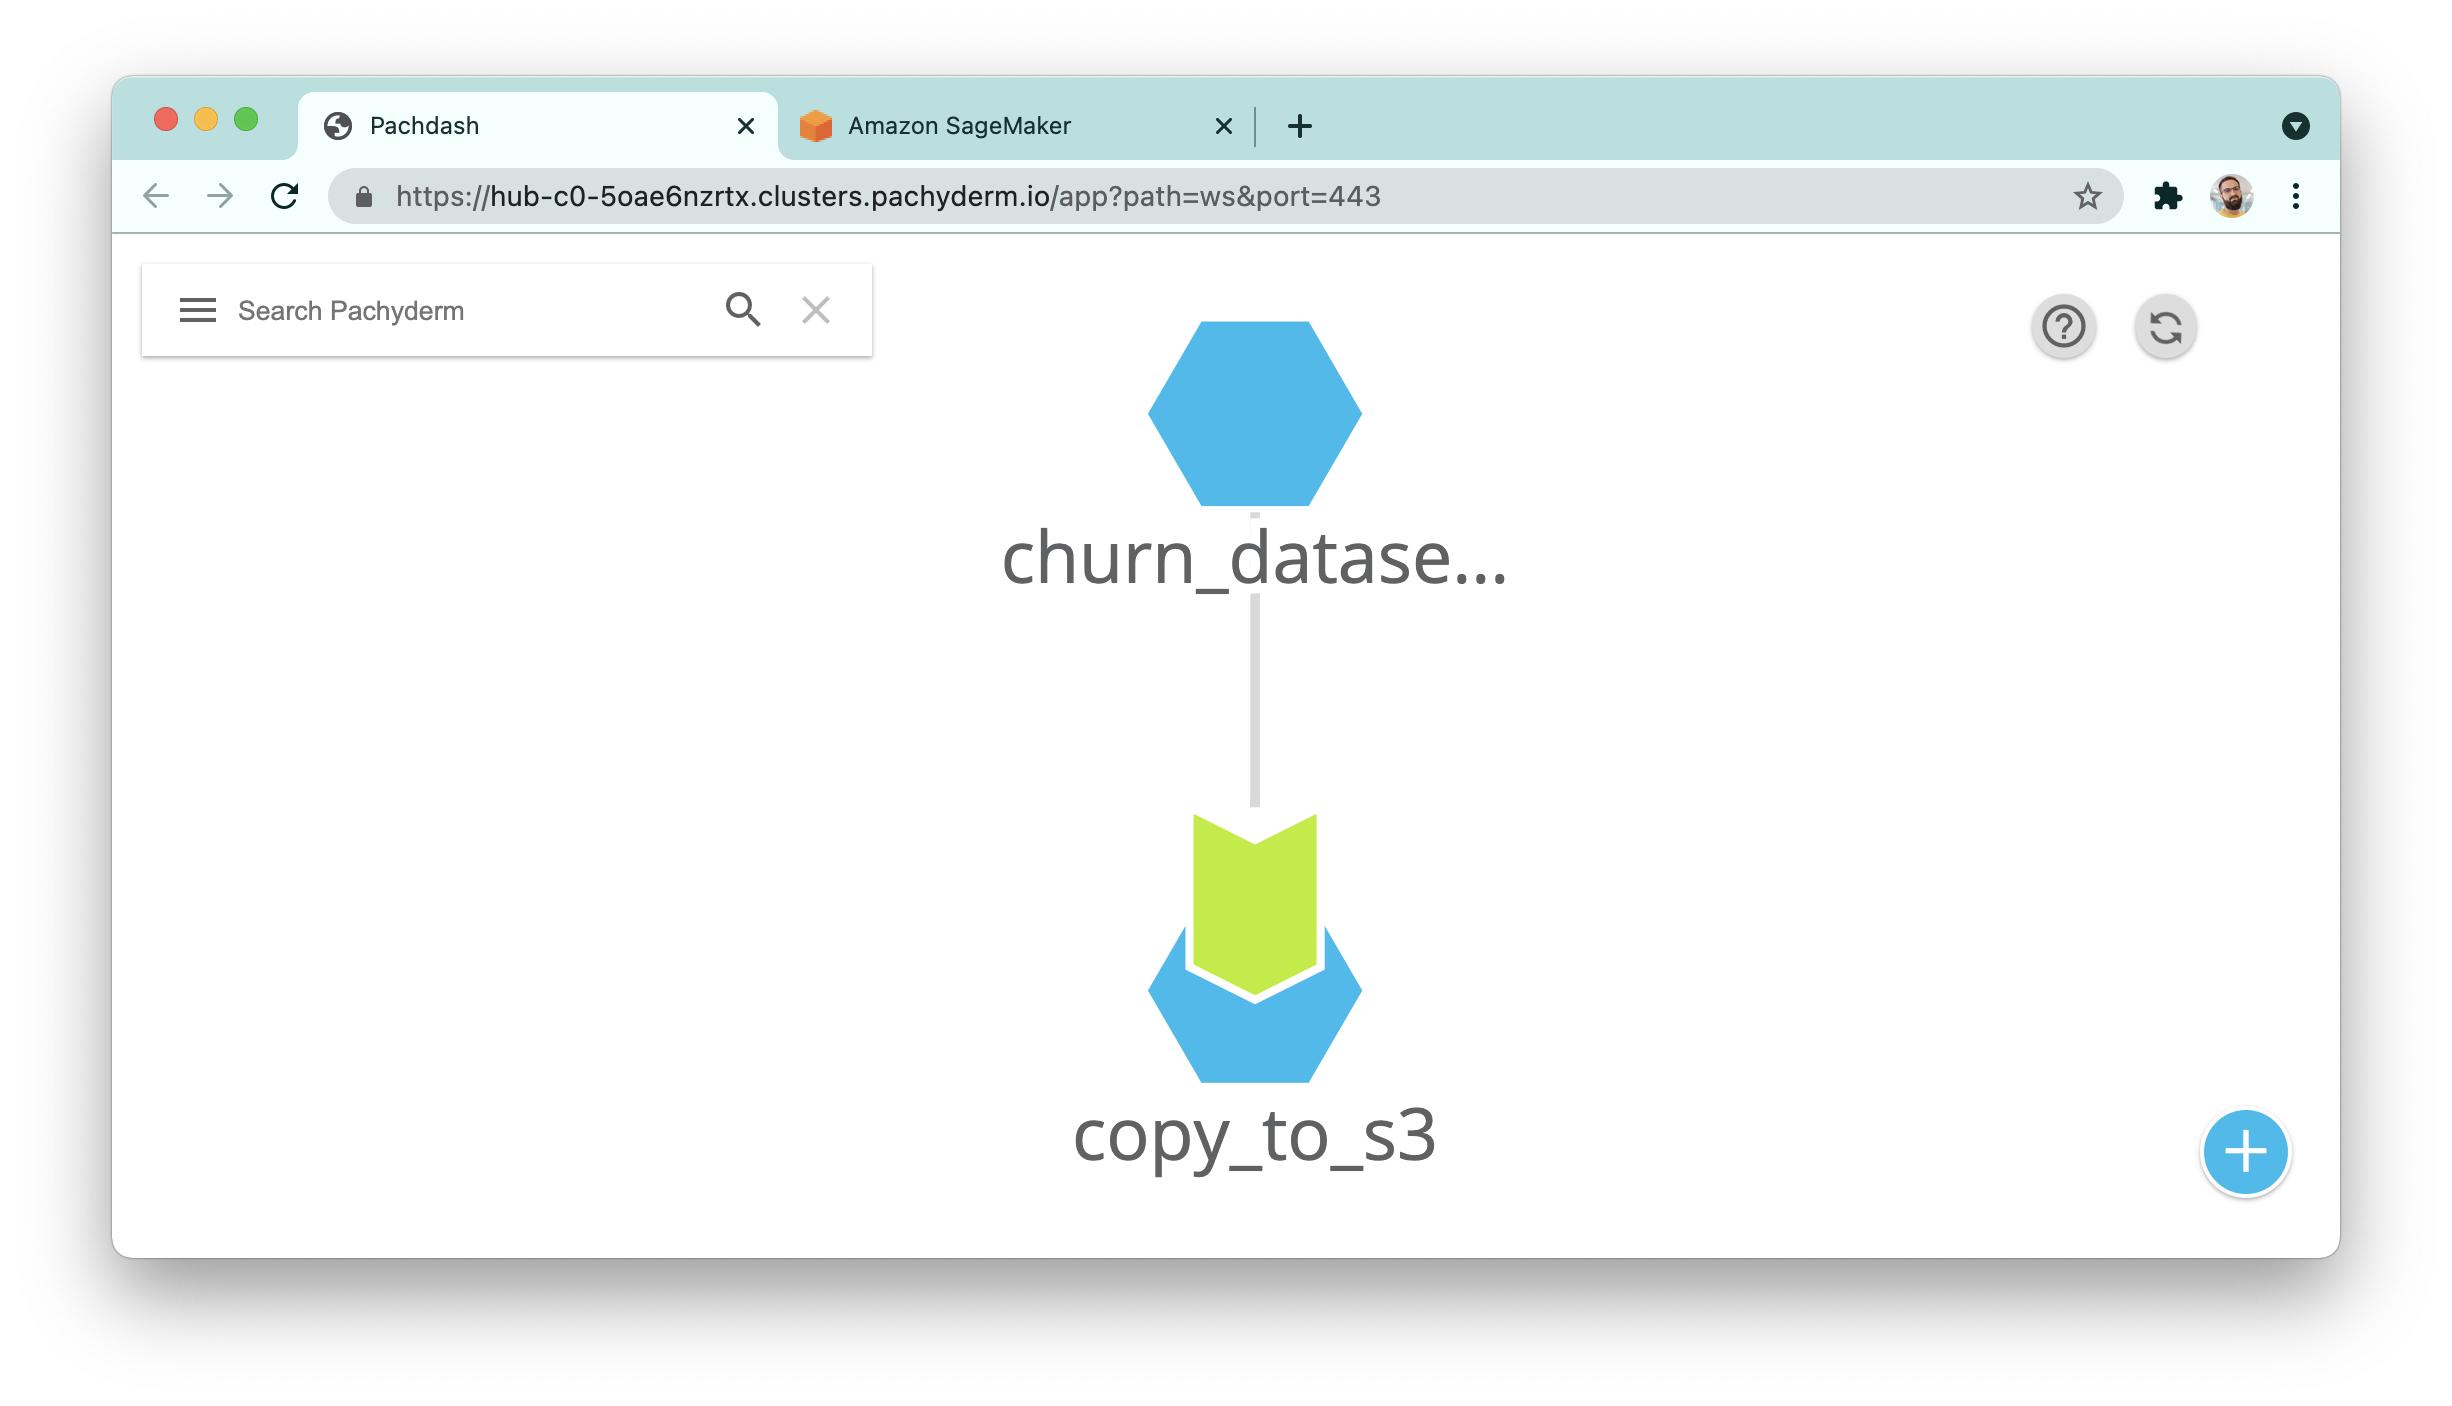

## Create pipeline: Train a ML Model on Sagemaker

Now that I've made the training data available on S3, it's time to create a training pipeline.
The pipeline below uses the Sagemaker SDK to create a Sagemaker job that fetches the input data from `BUCKET_NAME`, trains a XGBoost model, and makes the artifacts available in the same bucket.

XGBoost is an advanced ensamble decision-tree algorithm that uses extreme gradient boosting to tweak the model weights, for further details check [this article](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/).

### Important 

Training a model is a time consuming operation and Sagemaker executes it remotly in the AWS cloud.
To ensure the pipeline ends only when the training job has completed I must make sure the Sagemaker call is "blocking".
Thus, in the training script I enforce `wait=True` in `model.fit()`.

In [12]:
pipeline = """
{
  "pipeline": {
    "name": "train_on_sagemaker"
  },
  "reprocess_spec": "every_job",
  "description": "Launch a training job on Sagemaker from Pachyderm pipeline",
  "transform": {
    "image": "winderresearch/example-pachyderm-train-sagemaker:0.0.1",
    "cmd": ["/bin/bash"],
    "stdin": [
        "python -u /sage.py --bucket %s --role %s"
    ],
    "env": {
        "AWS_DEFAULT_REGION": "%s",
        "AWS_ACCESS_KEY_ID": "%s",
        "AWS_SECRET_ACCESS_KEY": "%s"
    }
  },
  "parallelism_spec": {
    "constant": "1"
  },
  "input": {
    "pfs": {
      "repo": "copy_to_s3",
      "branch": "master",
      "glob": "/"
    }
  }
}""" % (BUCKET_NAME, AWS_SAGEMAKER_ROLE, AWS_DEFAULT_REGION, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

print(pipeline, file=open('train_on_sagemaker.json', 'w'))

In [13]:
!pachctl create pipeline -f train_on_sagemaker.json

In [16]:
!pachctl flush commit train_on_sagemaker@master --raw > /dev/null 2>&1

In [17]:
!pachctl logs --pipeline=train_on_sagemaker

2021-08-11 10:02:11 Starting - Starting the training job...
2021-08-11 10:02:34 Starting - Launching requested ML instancesProfilerReport-1628676130: InProgress
...
2021-08-11 10:03:07 Starting - Preparing the instances for training.........
2021-08-11 10:04:47 Downloading - Downloading input data
2021-08-11 10:04:47 Training - Downloading the training image...
2021-08-11 10:05:15 Uploading - Uploading generated training modelArguments: train
[2021-08-11:10:05:09:INFO] Running standalone xgboost training.
[2021-08-11:10:05:09:INFO] File size need to be processed in the node: 1.16mb. Available memory size in the node: 8407.3mb
[2021-08-11:10:05:09:INFO] Determined delimiter of CSV input is ','
[10:05:09] S3DistributionType set as FullyReplicated
[10:05:09] 3500x99 matrix with 346500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-08-11:10:05:09:INFO] Determined delimiter of CSV input is ','
[10:05:09] S3DistributionType set as FullyReplicated
[10

Open Sagemaker and reach the `Training / Training jobs` page. 
Here you check see your job status and inspect its internal details.

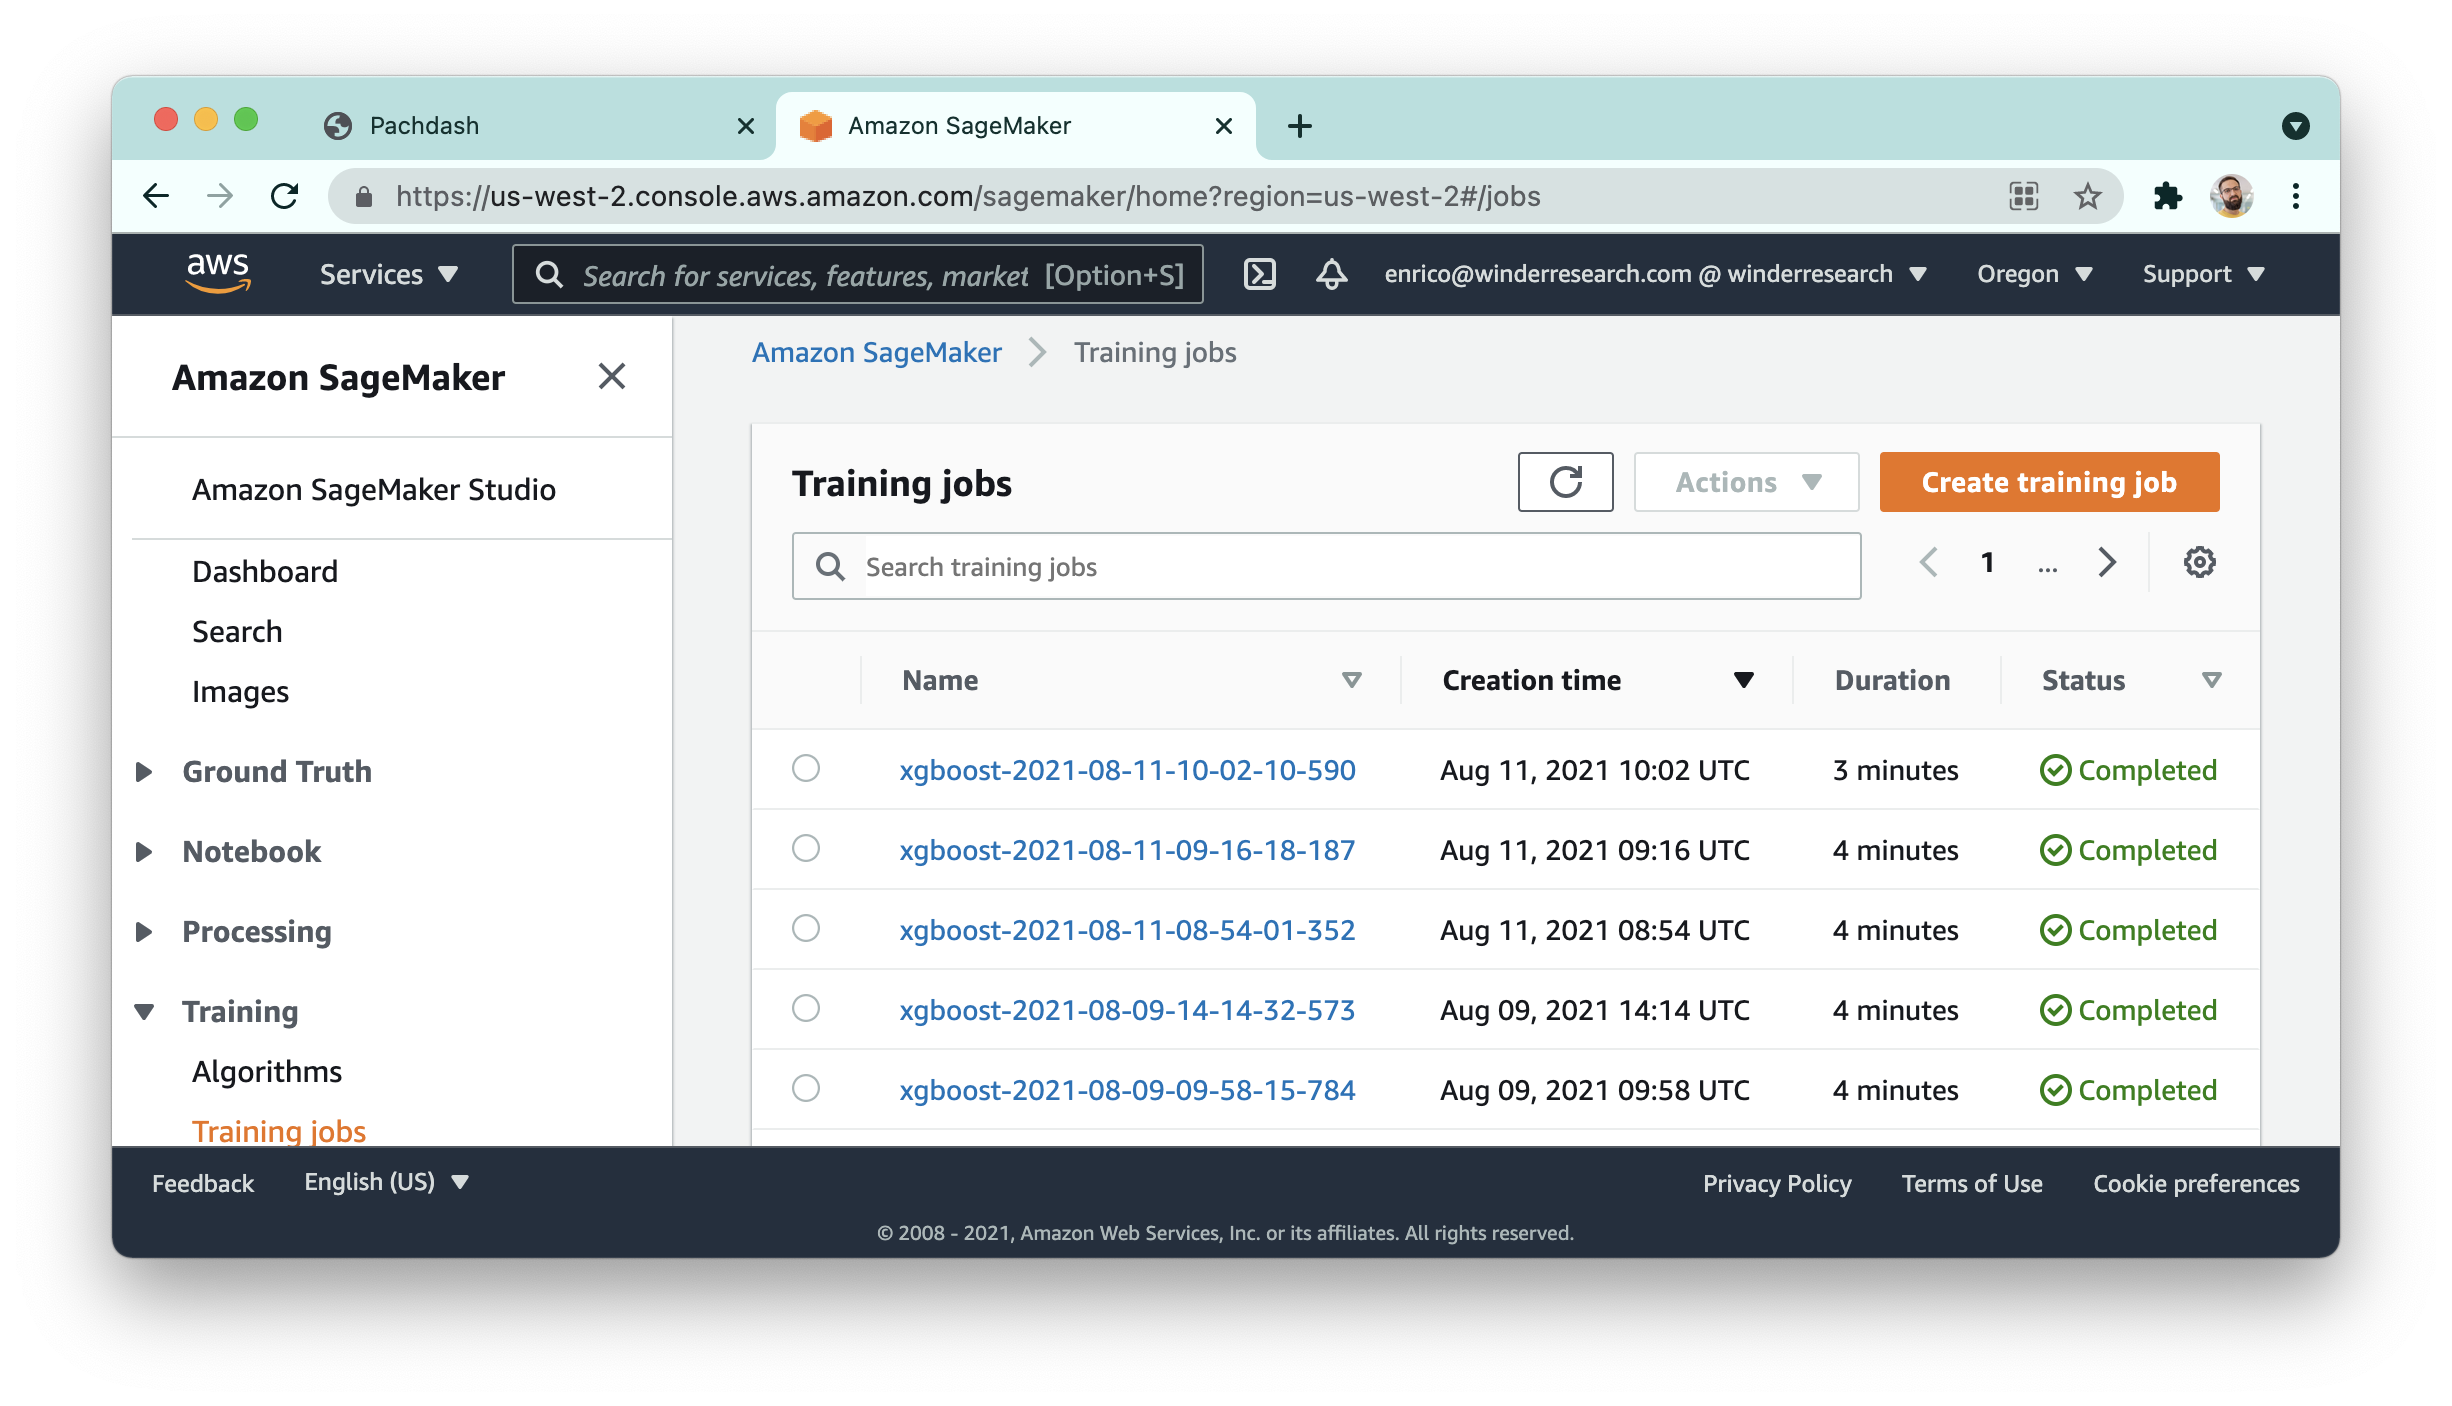

The run has produced some artifacts, stored on a bucket. Let's list some of them.

In [18]:
!aws s3 ls --recursive {AWS_BUCKET} | less

2021-08-11 12:05:17      47802 output/xgboost-2021-08-11-10-02-10-590/output/model.tar.gz
2021-08-11 12:05:21          0 output/xgboost-2021-08-11-10-02-10-590/profiler-output/framework/training_job_end.ts
2021-08-11 12:05:15     100313 output/xgboost-2021-08-11-10-02-10-590/profiler-output/system/incremental/2021081110/1628676240.algo-1.json
2021-08-11 12:05:15      58356 output/xgboost-2021-08-11-10-02-10-590/profiler-output/system/incremental/2021081110/1628676300.algo-1.json
2021-08-11 12:05:21          0 output/xgboost-2021-08-11-10-02-10-590/profiler-output/system/training_job_end.ts
2021-08-11 12:06:38     322339 output/xgboost-2021-08-11-10-02-10-590/rule-output/ProfilerReport-1628676130/profiler-output/profiler-report.html
2021-08-11 12:06:37     168684 output/xgboost-2021-08-11-10-02-10-590/rule-output/ProfilerReport-1628676130/profiler-output/profiler-report.ipynb
2021-08-11 12:06:33        190 output/xgboost-2021-08-11-10-02-10-590/rule-output/ProfilerReport-1628676130/prof

## Create pipeline: Download Trained Model from AWS S3 to Pachyderm

At this stage Sagemaker's job has finished but the resulting artifacts are not version controlled yet.
With this simple pipeline I pull download the training output into a repository where data lineage is guarateed by Pachyderm.

In [19]:
pipeline = """
{
  "pipeline": {
    "name": "download_from_s3"
  },
  "description": "Download training artifacts from AWS S3.",
  "transform": {
    "image": "winderresearch/example-pachyderm-copy-to-aws-s3:0.0.1",
    "cmd": ["/bin/bash"],
    "stdin": [
        "python -u ./aws_to_pach.py --src_bucket %s"
    ],
    "env": {
        "AWS_DEFAULT_REGION": "%s",
        "AWS_ACCESS_KEY_ID": "%s",
        "AWS_SECRET_ACCESS_KEY": "%s"
    }
  },
  "parallelism_spec": {
    "constant": "1"
  },
  "input": {
    "pfs": {
      "repo": "train_on_sagemaker",
      "branch": "master",
      "glob": "/"
    }
  }
}""" % (BUCKET_NAME, AWS_DEFAULT_REGION, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

print(pipeline, file=open('download_from_s3.json', 'w'))

In [20]:
!pachctl create pipeline -f download_from_s3.json

In [21]:
!pachctl flush commit download_from_s3@master --raw > /dev/null 2>&1

In [22]:
!pachctl logs --pipeline=download_from_s3

In [23]:
!pachctl list file download_from_s3@master:output

NAME                                    TYPE SIZE     
/output/xgboost-2021-08-11-10-02-10-590 dir  683.1KiB 



The final DAG will look like the following:



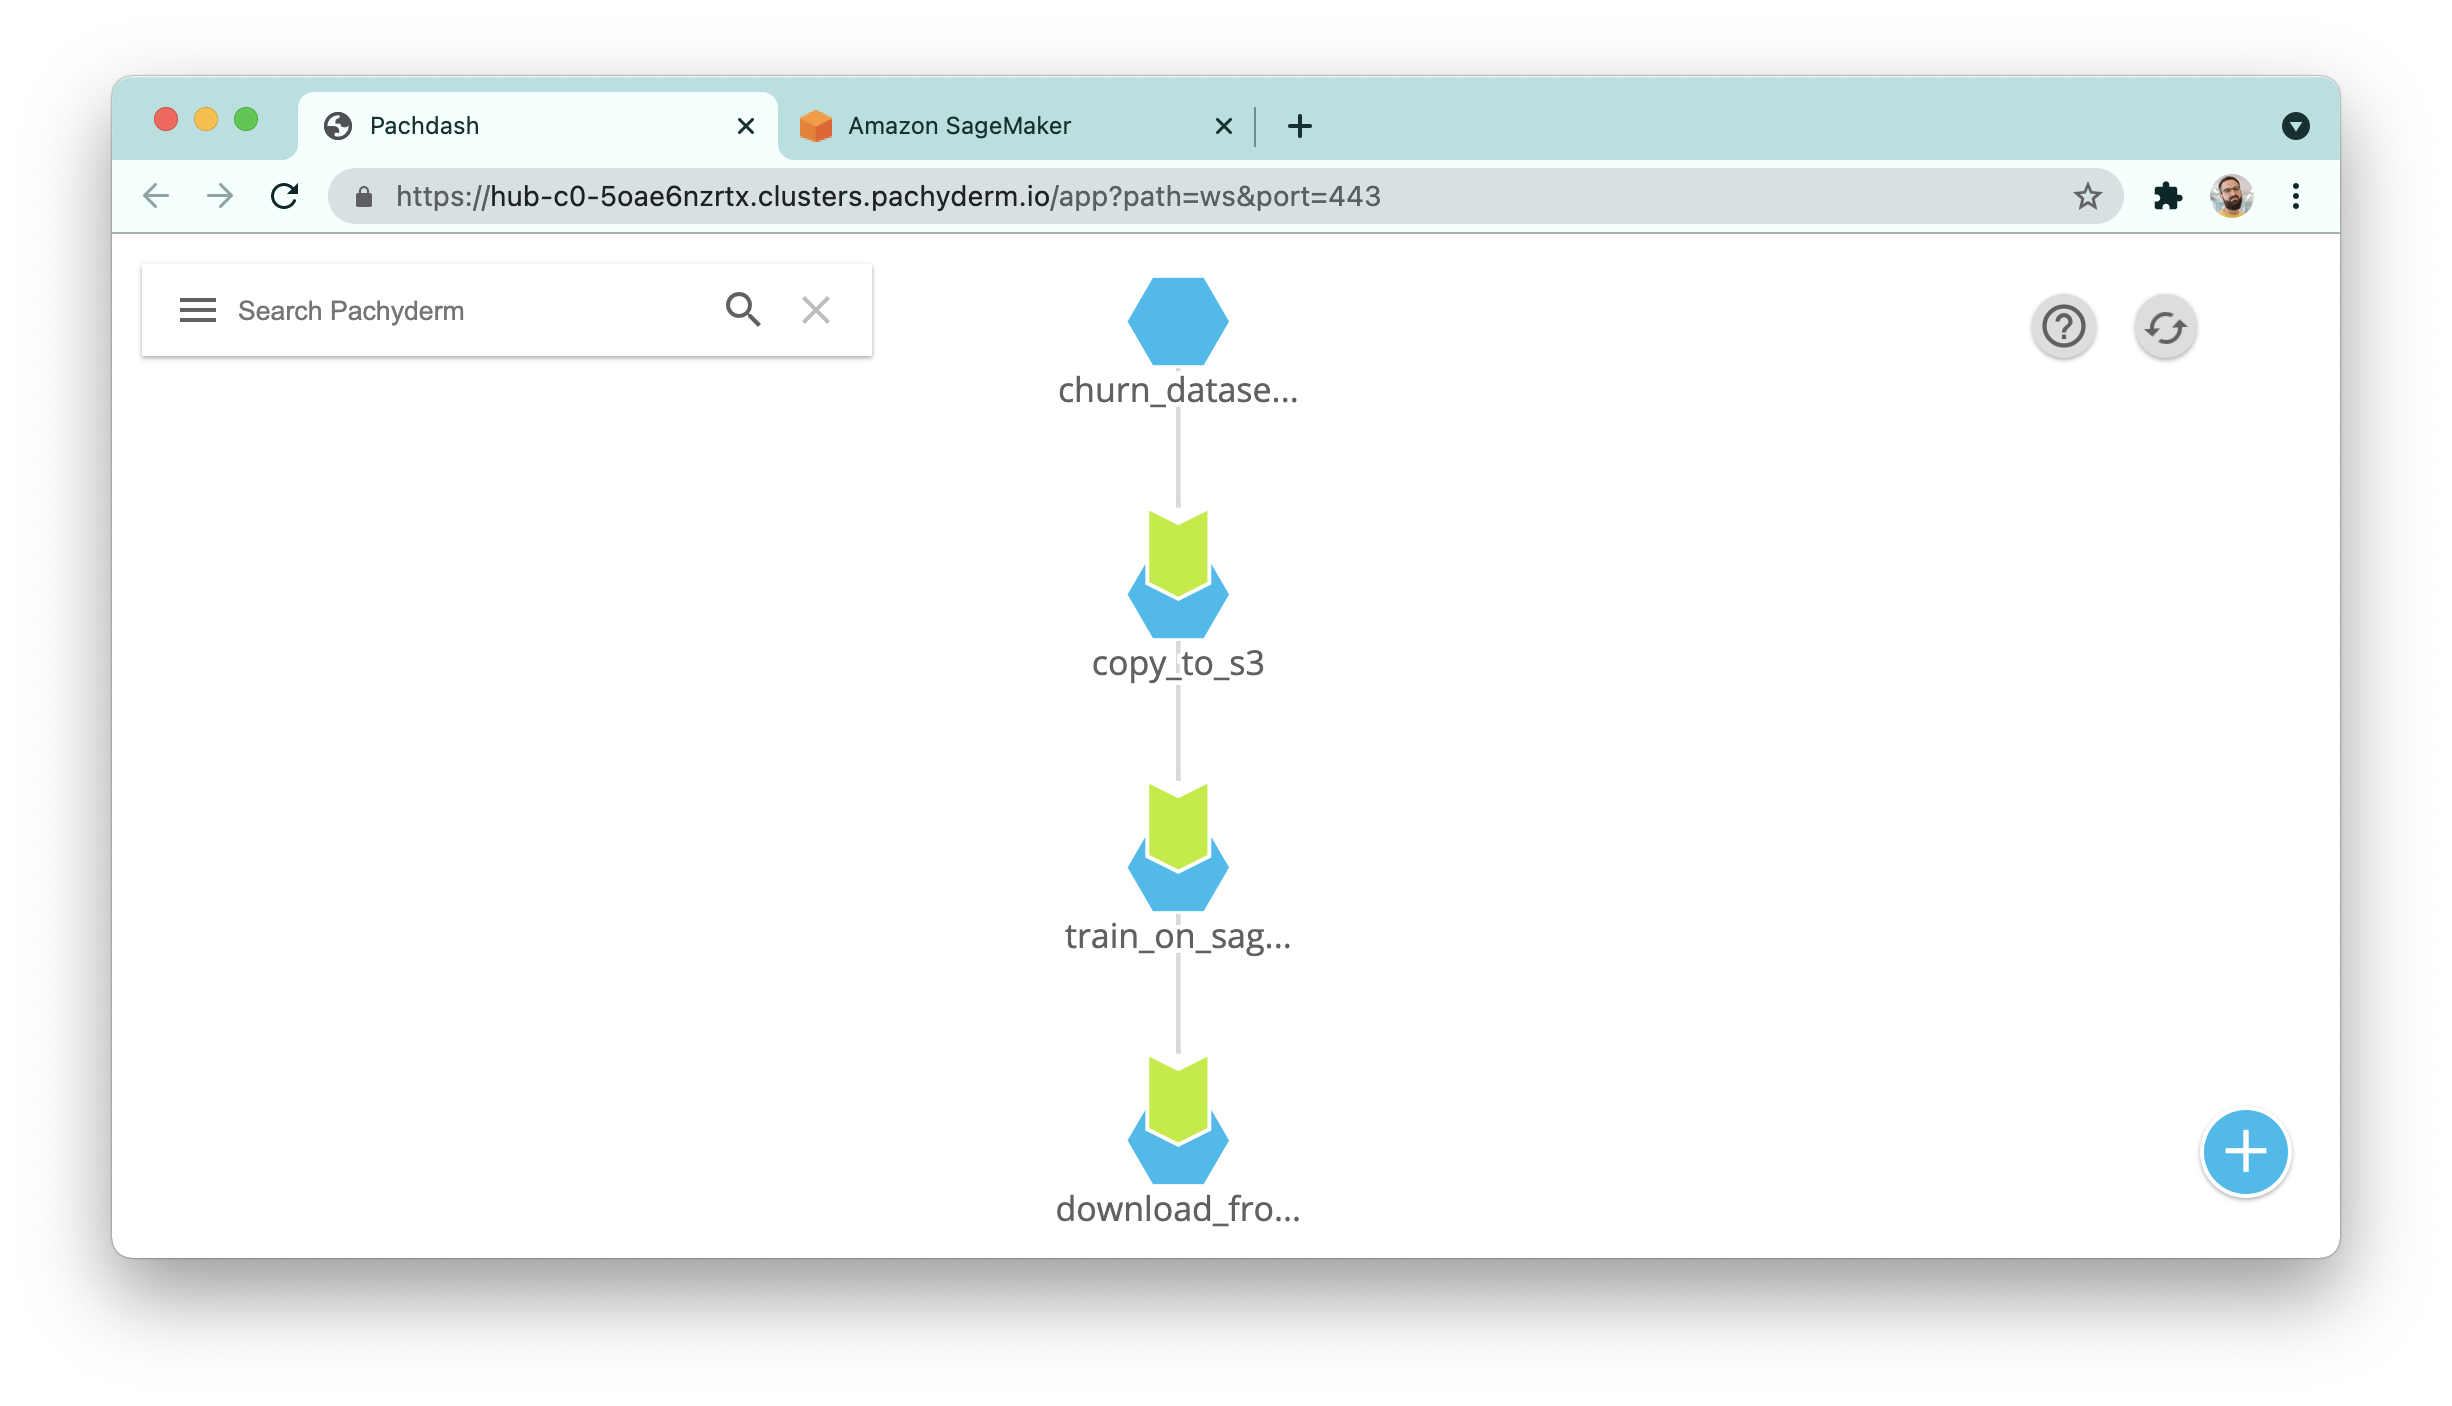

## Summary

In this demo I have shown how to use Pachyderm and Sagemaker to train a ML model for churn prediction.
Pachyderm is used to trigger a Sagemaker job and provide data lineage at any stage.
Sagemaker is used to offload the training job to the cloud, all you need to do is pick the right machine type.
This is all done in a few lines of code with the [Sagemaker Python SDK](https://sagemaker.readthedocs.io/en/stable/).
Note that a similar workflow would apply for many other Sagemaker features such as model deployment or data processing.